In [189]:
from __future__ import division,print_function
import numpy as np
import os,fnmatch
import read_params
from scipy.special import j0,j1,jn
from scipy import interpolate,integrate
def j2(z): return jn(2,z)
def dj1(z): return 0.5*(j0(z)-j2(z))
import matplotlib.pyplot as plt
import plotc
import pyfits
import itertools
%matplotlib inline

Lx = read_params.get_xlength()
nx = read_params.get_nx()
x = np.linspace(-Lx/2,Lx/2,nx,endpoint=False)
dx=Lx/nx
Rsun = 695.8
z,c = np.loadtxt(read_params.get_solarmodel(),usecols=[0,1],unpack=True);
z=(z-1)*Rsun
c/=100

# Basis

In [144]:
class spline_basis_coeffs():
        def __init__(self,true_coeffs,iter_coeffs,low_ind=0,high_ind=None):
            self.true = true_coeffs
            self.iterated = iter_coeffs
            self.low_ind = low_ind
            self.high_ind = high_ind if high_ind>0 else self.true.size+high_ind
            self.grad = None
            self.update = None
            self.size = self.iterated.size


        def get_true(self,low_ind=None,high_ind=None):
            return self.true[self.low_ind if low_ind is None else low_ind:
                                self.high_ind if high_ind is None else high_ind]

        def get_iterated(self,low_ind=None,high_ind=None):
            return self.iterated[self.low_ind if low_ind is None else low_ind:
                                self.high_ind if high_ind is None else high_ind]

        def get_update(self,low_ind=None,high_ind=None):
            return self.update[self.low_ind if low_ind is None else low_ind:
                                self.high_ind if high_ind is None else high_ind]

        def get_range(self):
            return np.array(range(self.low_ind,self.high_ind))
        
class supergranule():
    def __init__(self,**kwargs):
        self.__dict__.update(kwargs)

DH13 = supergranule(R = 15,
                    k = 2*np.pi/30,
                    sigmaz = 0.912,
                    z0 = -2.3,
                    v0 = 240)

In [151]:
datadir = read_params.get_directory()
def read_model(iterno=0):
    modelfile = os.path.join(datadir,'update','model_psi_'+str(iterno).zfill(2)+'_coeffs.npz')
    with np.load(modelfile) as f:
        return dict(f.items())

with np.load(os.path.join(datadir,"true_psi_coeffs.npz")) as f:
    
    tR = f["tR"]
    tz = f["tz"]
    cz_ref_top = f["cz_top"]
    cz_ref_bot = f["cz_bot"]
    kR = f["kR"]
    kz = f["kz"]
    z_spl_cutoff = f["z_spline_cutoff"]
    coeff_surf_cutoff_ind = f["c_surf_cutoff"]
    R_surf_cutoff = f["R_surf_cutoff"].item()

iter_model = read_model()

coeffs = {
    "z":spline_basis_coeffs(true_coeffs=cz_ref_bot,iter_coeffs=iter_model["cz_bot"],
    low_ind=0,high_ind=coeff_surf_cutoff_ind),

    "R":spline_basis_coeffs(true_coeffs=np.zeros_like(iter_model["cR"]),
    iter_coeffs=iter_model["cR"],low_ind=0,high_ind=R_surf_cutoff)
}

## Kernel

In [9]:
iterno = 0
K = np.squeeze(pyfits.getdata(os.path.join(datadir,"update","grad_psi_"+str(iterno).zfill(2)+".fits")))

### Functions to multiply the kernel

In [98]:
## Compute the function that multiplies the basis
f = np.sign(x)*j1(DH13.k*abs(x))*np.exp(-abs(x)/DH13.R)
df_by_dR = x*np.exp(-abs(x)/DH13.R)/DH13.R**2*(j1(DH13.k*abs(x))-np.pi*dj1(DH13.k*abs(x)))
g = interpolate.splev(z,(tz,cz_ref_top,kz),ext=1)

B_z = K*f[None,:]
B_R = K*df_by_dR[None,:]*g[:,None]

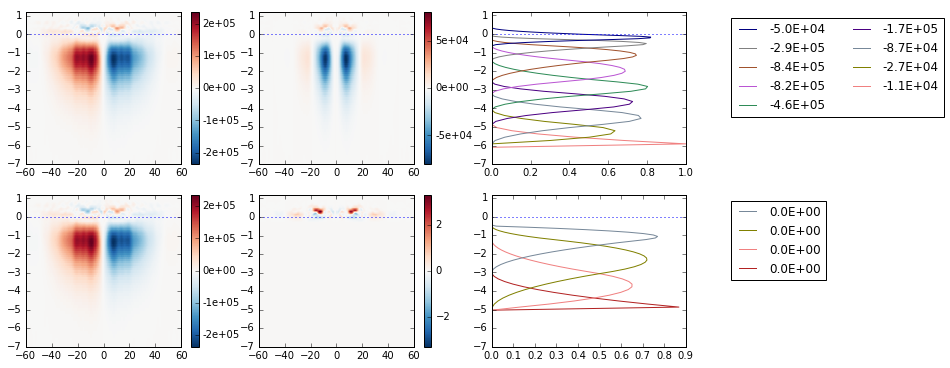

In [152]:
gl = plotc.gridlist(2,4)
plotc.colorplot(K,x=x,y=z,sp=next(gl),centerzero=True,xr=[-60,60],yr=[z_spl_cutoff.item()-1,None])
plotc.colorplot(B_z,x=x,y=z,sp=next(gl),centerzero=True,xr=[-60,60],yr=[z_spl_cutoff.item()-1,None])

lc = itertools.cycle(["lightcoral","olive","lightslategrey","indigo","seagreen",
                      "mediumorchid","sienna","gray","navy","firebrick"])

ax3=plt.subplot(next(gl))
for j in coeffs["z"].get_range():
    bj = np.zeros_like(coeffs["z"].iterated)
    bj[j] = 1
    bz = interpolate.splev(z,(tz,bj,kz),ext=1)
    plt.plot(bz,z,label="{:.1E}".format(integrate_2D(bz[:,None]*B_z)),color=next(lc))

plt.ylim(z_spl_cutoff.item()-1,z[-1])

plt.subplot(next(gl))
plt.legend(*map(lambda x: x[::-1],ax3.get_legend_handles_labels()),ncol=2,loc="upper left")
plt.axis("off")

plotc.colorplot(K,x=x,y=z,sp=next(gl),centerzero=True,xr=[-60,60],yr=[z_spl_cutoff.item()-1,None])
plotc.colorplot(B_R,x=x,y=z,sp=next(gl),centerzero=True,xr=[-60,60],yr=[z_spl_cutoff.item()-1,None])

ax7 = plt.subplot(next(gl))
for j in coeffs["R"].get_range():
    qj = np.zeros_like(coeffs["R"].iterated)
    qj[j] = 1
    qz = interpolate.splev(z,(tR,qj,kR),ext=1)
    plt.plot(qz,z,label="{:.1E}".format(integrate_2D(qz[:,None]*B_R)),color=next(lc))

plt.ylim(z_spl_cutoff.item()-1,z[-1])

plt.subplot(next(gl))
plt.legend(*map(lambda x:x[::-1],ax7.get_legend_handles_labels()),loc="upper left")
plt.axis("off")

for ax in plt.gcf().get_axes():
    ax.axhline(0,ls="dotted")

plt.gcf().set_size_inches(16,6);

## Basis gradients

In [153]:
grad_c = np.zeros(coeffs["z"].size)
grad_R = np.zeros(coeffs["R"].size)

def integrate_2D(arr):
    # Assume (nz,nx) format
    return integrate.simps(integrate.simps(arr,dx=dx,axis=1),x=z,axis=0)

for j,_ in enumerate(coeffs["z"].get_iterated()):
    bj = np.zeros_like(grad_c)
    bj[j] = 1
    bz = interpolate.splev(z,(tz,bj,kz),ext=1)
    grad_c[j] = integrate_2D(bz[:,None]*B_z)

for j,_ in enumerate(coeffs["R"].get_iterated()[:R_surf_cutoff]):
    qj = np.zeros_like(grad_R)
    qj[j] = 1
    qz = interpolate.splev(z,(tR,qj,kR),ext=1)
    grad_R[j] = integrate_2D(qz[:,None]*B_R)
    
np.set_printoptions(linewidth=200,precision=3,formatter={'float': lambda x: format(x, '5.1E')})
print("{:6s}".format("Grad"),grad_c[coeffs["z"].get_range()])
update_z = -grad_c[coeffs["z"].get_range()]/abs(grad_c).max()
print("{:6s}".format("Update"),update_z)
print("{:6s}".format("True"),coeffs["z"].get_true())
print("{:6s}".format("Ratio"),coeffs["z"].get_true()/update_z)
print()
print("{:6s}".format("Grad"),grad_R[coeffs["R"].get_range()])
print("{:6s}".format("True"),coeffs["R"].get_true())

Grad   [-1.1E+04 -2.7E+04 -8.7E+04 -1.7E+05 -4.6E+05 -8.2E+05 -8.4E+05 -2.9E+05 -5.0E+04]
Update [1.3E-02 3.3E-02 1.0E-01 2.0E-01 5.4E-01 9.8E-01 1.0E+00 3.4E-01 5.9E-02]
True   [1.1E-05 -2.2E-05 4.8E-04 4.9E-03 1.7E-02 2.7E-02 1.2E-02 6.0E-03 4.1E-03]
Ratio  [8.8E-04 -6.7E-04 4.7E-03 2.5E-02 3.1E-02 2.7E-02 1.2E-02 1.7E-02 6.9E-02]

Grad   [0.0E+00 0.0E+00 0.0E+00 0.0E+00]
True   [0.0E+00 0.0E+00 0.0E+00 0.0E+00]


# No basis

In [187]:
datadir = read_params.get_directory()
iterno = 1
K = np.squeeze(pyfits.getdata(os.path.join(datadir,"update","nospline_zcutoff",
                                           "gradient_psi_"+str(iterno).zfill(2)+".fits")))
psi_true = np.squeeze(pyfits.getdata(read_params.get_true_psi_filename()))

In [170]:
z_cutoff = -6 # Spline lower cutoff
zspline = z[z>z_cutoff]
nz_max,nx_max = np.unravel_index(psi_true.argmax(),psi_true.shape)

In [177]:
s_true = 1e-6
t_true,c_true,k_true = interpolate.splrep(zspline,psi_true[zspline_ind,nx_max],k=2,s=s_true)

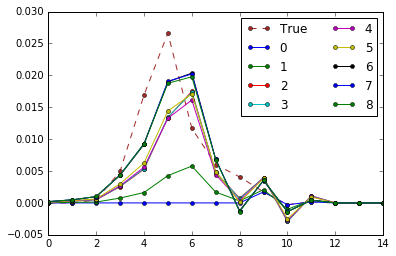

In [190]:
plt.plot(c_true,marker='o',color='brown',markersize=4,label="True",ls="dashed");
nmodels = len(fnmatch.filter(os.listdir(os.path.join(datadir,"update","nospline_zcutoff")),"model_psi_[0-9][0-9].fits"))
for iterno in xrange(nmodels):
    psi_model = np.squeeze(pyfits.getdata(os.path.join(datadir,"update","nospline_zcutoff",
                                                       "model_psi_"+str(iterno).zfill(2)+".fits")))
    psi_model-=psi_model[0,0]
    t_model,c_model,k_model = interpolate.splrep(zspline,
                            psi_model[zspline_ind,nx_max],k=k_true,s=s_true,task=-1,t=t_true[k_true+1:-k_true-1])
    plt.plot(c_model,marker='o',markersize=4,label=str(iterno));
plt.legend(loc="best",ncol=2);

# Comparison

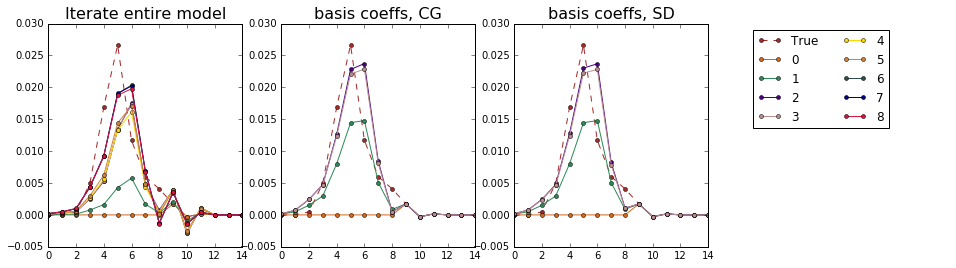

In [211]:
datadir = read_params.get_directory()
gl=plotc.gridlist(1,4)

lc = ["chocolate","seagreen","indigo","rosybrown","gold","peru","darkslategrey","navy","crimson"]

ax=plt.subplot(next(gl))
plt.plot(c_true,marker='o',color='brown',markersize=4,label="True",ls="dashed");
nmodels = len(fnmatch.filter(os.listdir(os.path.join(datadir,"update","nospline_zcutoff")),"model_psi_[0-9][0-9].fits"))
for iterno in xrange(nmodels):
    psi_model = np.squeeze(pyfits.getdata(os.path.join(datadir,"update","nospline_zcutoff",
                                                       "model_psi_"+str(iterno).zfill(2)+".fits")))
    psi_model-=psi_model[0,0]
    t_model,c_model,k_model = interpolate.splrep(zspline,
                            psi_model[zspline_ind,nx_max],k=k_true,s=s_true,task=-1,t=t_true[k_true+1:-k_true-1])
    plt.plot(c_model,marker='o',markersize=4,label=str(iterno),color=lc[iterno%len(lc)]);
plt.title("Iterate entire model",fontsize=16)

plt.subplot(next(gl))
plt.plot(cz_ref_top+cz_ref_bot,marker='o',color='brown',markersize=4,label="True",ls="dashed");
nmodels = len(fnmatch.filter(os.listdir(os.path.join(datadir,"update")),"model_psi_[0-9][0-9].fits"))
for iterno in xrange(nmodels):
    with np.load(os.path.join(datadir,"update","model_psi_{:02d}_coeffs.npz".format(iterno))) as mf:
        c_model_bot = mf["cz_bot"]
    plt.plot(cz_ref_top+c_model_bot,marker='o',markersize=4,label=str(iterno),color=lc[iterno%len(lc)]);
plt.title("basis coeffs, CG",fontsize=16)

plt.subplot(next(gl))
sd_dir = "/scratch/jishnu/flows/spline_z_R_sd/update"
plt.plot(cz_ref_top+cz_ref_bot,marker='o',color='brown',markersize=4,label="True",ls="dashed");
nmodels = len(fnmatch.filter(os.listdir(sd_dir),"model_psi_[0-9][0-9].fits"))
for iterno in xrange(nmodels):
    with np.load(os.path.join(sd_dir,"model_psi_{:02d}_coeffs.npz".format(iterno))) as mf:
        c_model_bot = mf["cz_bot"]
    plt.plot(cz_ref_top+c_model_bot,marker='o',markersize=4,label=str(iterno),color=lc[iterno%len(lc)]);
plt.title("basis coeffs, SD",fontsize=16)

plt.subplot(next(gl))
plt.legend(*ax.get_legend_handles_labels(),loc="upper left",ncol=2)
plt.axis("off")

plt.gcf().set_size_inches(16,4)

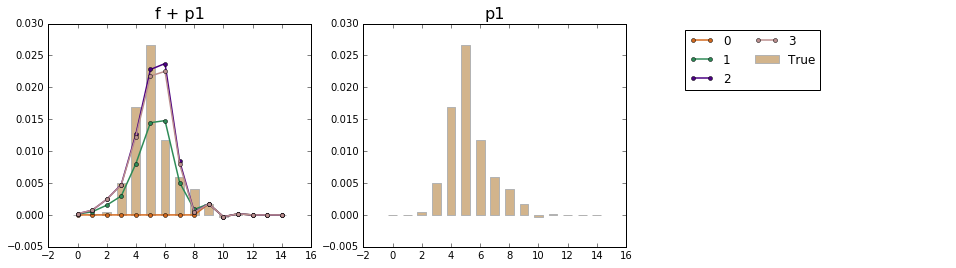

In [228]:
datadir = read_params.get_directory()
gl=plotc.gridlist(1,3)

lc = ["chocolate","seagreen","indigo","rosybrown","gold","peru","darkslategrey","navy","crimson"]

ax=plt.subplot(next(gl))
plt.bar(np.arange(c_true.size)-0.3,cz_ref_top+cz_ref_bot,width=0.6,color='tan',label="True",ec="0.7");
nmodels = len(fnmatch.filter(os.listdir(os.path.join(datadir,"update")),"model_psi_[0-9][0-9].fits"))
for iterno in xrange(nmodels):
    with np.load(os.path.join(datadir,"update","model_psi_{:02d}_coeffs.npz".format(iterno))) as mf:
        c_model_bot = mf["cz_bot"]
    plt.plot(cz_ref_top+c_model_bot,marker='o',markersize=4,label=str(iterno),color=lc[iterno%len(lc)],lw=1.5);
plt.title("f + p1",fontsize=16)

plt.subplot(next(gl))
sd_dir = "/scratch/jishnu/flows/spline_z_R_sd/update"
plt.bar(np.arange(c_true.size)-0.3,cz_ref_top+cz_ref_bot,width=0.6,color='tan',label="True",ec="0.7");
nmodels = len(fnmatch.filter(os.listdir(sd_dir),"model_psi_[0-9][0-9].fits"))
for iterno in xrange(nmodels):
    with np.load(os.path.join(sd_dir,"model_psi_{:02d}_coeffs.npz".format(iterno))) as mf:
        c_model_bot = mf["cz_bot"]
    plt.plot(cz_ref_top+c_model_bot,marker='o',markersize=4,label=str(iterno),color=lc[iterno%len(lc)],lw=1.5);
plt.title("p1",fontsize=16)

plt.subplot(next(gl))
plt.legend(*ax.get_legend_handles_labels(),loc="upper left",ncol=2)
plt.axis("off")

plt.gcf().set_size_inches(16,4)